# Fitting the background

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u

import corner
import pystan
import pymc3
import pickle
import os

Lets read in the data

In [2]:
locs = np.genfromtxt('../locs.txt')
lo = locs.flatten().min() - 50.
hi = locs.flatten().max() + 50.

In [3]:
ff = np.genfromtxt('../freqs.txt')
pp = np.genfromtxt('../model.txt')
sel = (ff > lo) & (ff < hi)
f = ff[~sel]
p = pp[~sel]

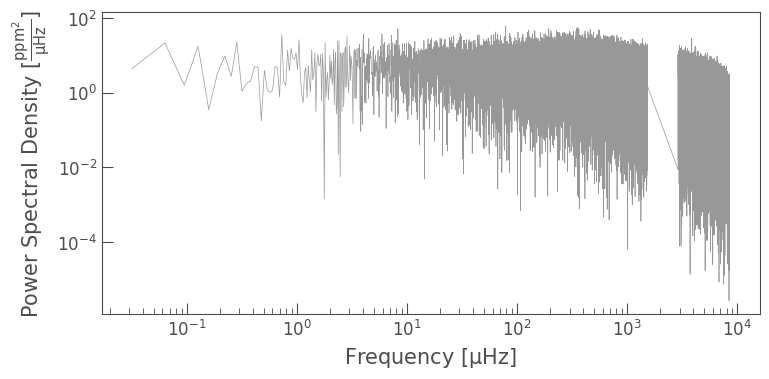

In [4]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5,scale='log')
# pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2, scale='log')
plt.show()

In [5]:
overwrite = False
backfit = '''
functions {
    real harvey(real f, real a, real b, real c){
        return 0.9*a^2/b/(1.0 + (f/b)^c);
    }
    real apod(real f, real nyq){
        real x = 3.14 / 2.0 * f / nyq;
        return (sin(x) / x)^2;
    }
}
data {
    int N;
    vector[N] f;
    real p[N];
    real white_est;
    real nyq_est;
    real numax_est;
    real scale_spread;
}
parameters {
    real<lower = 0> a;
    real<lower = 0> b;
    real<lower = 0> c;
    real<lower = 0> d;
    real<lower = 0> j;
    real<lower = 0> k;
    real<lower = 0> numax;
    real<lower = 0> white;
    real<lower = 0> nyq;
    real scale;
}
transformed parameters {
    real loga;
    real logb;
    real logc;
    real logd;
    real logj;
    real logk;
    real log_ac;
    real lognumax;
    
    loga = log10(a);
    logb = log10(b);
    logc = log10(c);
    logd = log10(d);
    logj = log10(j);
    logk = log10(k);
    log_ac = loga - logc;
    
    lognumax = log10(numax);

}
model {
    real beta[N];
    for (i in 1:N){
        beta[i] = 1. / (apod(f[i], nyq) * scale
                * (harvey(f[i], a, b, 4.0)
                + harvey(f[i], c, d, 4.0)
                + harvey(f[i], j, k, 2.0))
                + white);
        }
    p ~ gamma(1., beta);
    
    numax ~ normal(numax_est, numax_est*0.1);
    white ~ normal(white_est, white_est*0.3);
    
    loga ~ normal(3.4 + lognumax * -0.48, 0.3);
    logb ~ normal(-0.43 + lognumax * 0.86, 0.3);
    logc ~ normal(3.59 + lognumax * -0.59, 0.3);
    logd ~ normal(0.02 + lognumax * 0.96, 0.3);
    logj ~ normal(loga-1, 1.2);
    logk ~ normal(logb-1, 0.2);
    nyq ~ normal(nyq_est, nyq_est*0.01);
    scale ~ normal(1, scale_spread);
}
'''
model_path = 'backfit.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = backfit, model_name='backfit')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()
if os.path.isfile(model_path):
    print('Reading in Stan model')
    sm = pickle.load(open(model_path, 'rb'))
else:
    print('Saving Stan Model')
    sm = pystan.StanModel(model_code = backfit, model_name='backfit')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()

Reading in Stan model


Guess the parameters

In [7]:
def guess(numax):
    ak, ae = 3.3, -0.48
    bk, be = -0.43, 0.86
    ck, ce = 3.59, -0.59
    dk, de = 0.02, 0.96

    a = 10**(ak + np.log10(numax)*ae)
    b = 10**(bk + np.log10(numax)*be)
    c = 10**(ck + np.log10(numax)*ce)
    d = 10**(dk + np.log10(numax)*de)
    j = a * 0.5
    k = b / 40.0
    scale = 1.0
    
    return [a, b, c, d, j, k, numax]

In [9]:
numax = 2200
white = 1.
p0 = guess(numax)

data = {'N': len(f), 
        'f': f, 'p': p,
        'numax_est': numax, 'white_est': white,
        'nyq_est': np.max(f),
        'scale_spread': 0.01}

init = {'a': p0[0], 'b': p0[1], 'c': p0[2], 'd': p0[3],
        'j': p0[4], 'k': p0[5],
        'numax': p0[6],
        'white': white, 'nyq': np.max(f),
        'scale': 0.7}

In [10]:
nchains = 4
fit = sm.sampling(data=data, iter=1000, chains=nchains, 
                  init = [init for n in range(nchains)])

KeyboardInterrupt: 

In [ ]:
print(fit)

In [ ]:
fit.plot()
plt.show()

In [ ]:
a = 36.3                                                                
b = 723.52                                                              
c = 31.85                                                               
d = 2002.6                                                              
j = 1.79                                                                
k = 198.31                                                              
white = 0.09  
truths = [a, b, c, d, j, k, white, 1., f[-1]]

In [ ]:
labels=['a','b','c','d','j','k','white','scale','nyq']
chain = np.array([fit[label] for label in labels])
corner.corner(chain.T, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

In [ ]:
def harvey(f, a, b, c):
    #The harvey profile seems to take different forms depending on who I ask?
    #I'm going to be using the one used in Guy's BackFit code. Why is it different?
    harvey = 0.9*a**2/b/(1.0 + (f/b)**c);

    return harvey

def get_apodization(freqs, nyquist):
    x = (np.pi * freqs) / (2 * nyquist)
    return (np.sin(x)/x)**2

def get_background(f, a, b, c, d, j, k, white, scale, nyq):
    #I did a fit to 16CygA using Guy's backfit program. I'm lifting the
    #Harvey components from there

    background = np.zeros(len(f))
    background += get_apodization(f, nyq)**2 * scale\
                    * (harvey(f, a, b, 4.) + harvey(f, c, d, 4.) + harvey(f, j, k, 2.))\
                    + white
    return background

res = [np.median(fit[label]) for label in labels]
model = get_background(f, *res)

In [ ]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.25, label='Data', scale='log')
ax.plot(f, model, label='Model')
ax.plot(f, harvey(f, *res[0:2], 4.), label='Harvey 1', ls=':')
ax.plot(f, harvey(f, *res[2:4], 4.), label='Harvey 2', ls=':')
ax.plot(f, harvey(f, *res[4:6], 2.), label='Harvey 3', ls=':')
ax.plot(f, get_apodization(f, f[-1]), label='Apod', ls='--')
ax.plot(f, res[-3]*np.ones_like(f), label='white',ls='-.')
plt.legend(fontsize=10)